In [1]:
from typing import Iterable
from pathlib import Path

import numpy as np
import pandas as pd

from Data_manager.split_functions.split_train_validation_random_holdout import (
    split_train_in_two_percentage_global_sample,
)
from Data_manager.competition import CompetitionReader
from Data_manager.Dataset import Dataset
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import (
    ItemKNN_CFCBF_Hybrid_Recommender,
)
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.Hybrid import ScoresHybridRecommender

In [2]:
TEST_ID_PATH = Path("/home/tomaz/git/Politecnico/Subjects/recommender-systems/recsys-competition/Data_manager_split_datasets/competition/data_target_users_test.csv")
TEST_ID_PATH.exists()

True

In [3]:
SUBMISSION_PATH = Path("submission.csv")

In [4]:
test_df = pd.read_csv(TEST_ID_PATH, dtype="string")
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34231 entries, 0 to 34230
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  34231 non-null  string
dtypes: string(1)
memory usage: 267.6 KB
None


,user_id
0,0
1,1
2,2
3,3
4,4
...,...
34226,35729
34227,35730
34228,35731
34229,35734


In [5]:
data_reader = CompetitionReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()
ICM_all = data_loaded.get_ICM_from_name("ICM_all")

URM_train, URM_test = split_train_in_two_percentage_global_sample(
    URM_all, train_percentage=0.8
)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(
    URM_train, train_percentage=0.8
)

competition: Verifying data consistency...
competition: Verifying data consistency... Passed!
DataReader: current dataset is: competition
	Number of items: 38121
	Number of users: 35736
	Number of interactions in URM_all: 1764607
	Value range in URM_all: 1.00-1.00
	Interaction density: 1.30E-03
	Interactions per user:
		 Min: 1.20E+01
		 Avg: 4.94E+01
		 Max: 5.90E+03
	Interactions per item:
		 Min: 1.20E+01
		 Avg: 4.63E+01
		 Max: 1.47E+03
	Gini Index: 0.43

	ICM name: ICM_all, Value range: 1.00 / 1.00, Num features: 94331, feature occurrences: 2940040, density 8.18E-04




In [6]:
cutoff_list = [5, 10, 15]

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 488 ( 1.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 159 ( 0.4%) Users that have less than 1 test interactions


In [7]:
BEST_ITEM_KNN_CF_CBF = {
    "topK": 96,
    "shrink": 966,
    "similarity": "cosine",
    "normalize": True,
    "feature_weighting": "BM25",
    "ICM_weight": 0.015154282137075726,
}

itemknn_cfcbf_recommender = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_all)
itemknn_cfcbf_recommender.fit(**BEST_ITEM_KNN_CF_CBF)

Similarity column 38121 (100.0%), 755.75 column/sec. Elapsed time 50.44 sec


In [27]:
result_df, _ = evaluator_validation.evaluateRecommender(itemknn_cfcbf_recommender)
result_df

EvaluatorHoldout: Processed 35283 (100.0%) in 32.85 sec. Users per second: 1074


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.073265,0.086783,0.061445,0.043158,0.050751,0.165739,0.087111,0.066837,0.288354,0.189111,...,0.987324,0.284699,0.987324,0.250446,13.556445,0.999911,0.41411,0.918643,0.877103,0.158371
10,0.059315,0.105443,0.095879,0.026897,0.04716,0.180242,0.094092,0.07329,0.397387,0.218901,...,0.987324,0.392349,0.987324,0.300884,13.828739,0.999935,0.497509,0.937095,0.882573,0.317054
15,0.051407,0.126743,0.121856,0.019962,0.048343,0.185596,0.102571,0.072309,0.465352,0.232829,...,0.987324,0.459453,0.987324,0.333323,13.979426,0.999948,0.551147,0.947306,0.87958,0.476179


## Hybrid of models with the same structure

The underlying idea is that if you have some models with the same underlying structure, you can merge them in a single one. The result is to define a function that give the various model's parameters creates a new model with its own parameters.
In this example we will see how to combine different item-item similarity models in a new one.

In particular: `ItemKNNCFRecommender` and `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.

In [8]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit()

Similarity column 38121 (100.0%), 6415.04 column/sec. Elapsed time 5.94 sec


In [9]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

P3alphaRecommender: Similarity column 38121 (100.0%), 4149.72 column/sec. Elapsed time 9.19 sec


Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [10]:
itemKNNCF.W_sparse

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1906050 stored elements and shape (38121, 38121)>

In [12]:
P3alpha.W_sparse

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2561106 stored elements and shape (38121, 38121)>

When we create hybrids we always have to account for:
* A weight, which is a hyperparameter to tune. 
* What is the range and distribution of the values we are merging

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

In [13]:
alpha = 0.7
new_similarity = (1 - alpha) * itemKNNCF.W_sparse + alpha * P3alpha.W_sparse
new_similarity

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3914572 stored elements and shape (38121, 38121)>

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

The framework includes a recommender class which supports a custom similarity

In [14]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import (
    ItemKNNCustomSimilarityRecommender,
)

recommender_object = ItemKNNCustomSimilarityRecommender(URM_train)
recommender_object.fit(new_similarity)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

EvaluatorHoldout: Processed 35320 (100.0%) in 23.33 sec. Users per second: 1514


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,NOVELTY,AVERAGE_POPULARITY,DIVERSITY_MEAN_INTER_LIST,DIVERSITY_HERFINDAHL,COVERAGE_ITEM,COVERAGE_ITEM_HIT,ITEMS_IN_GT,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.076059,0.089631,0.063298,0.045114,0.052915,0.173543,0.090707,0.069094,0.299434,0.197859,0.001785,0.147823,0.99698,0.99939,0.393484,0.125338,0.98851,0.988359,0.295948,0.988359,0.10623,12.108776,0.999448,0.175546,0.8205,2.034168,0.145901
10,0.060892,0.10805,0.098201,0.027962,0.048953,0.188063,0.097297,0.075172,0.408296,0.227908,0.003599,0.138096,0.995414,0.999539,0.536686,0.179324,0.98851,0.988359,0.403543,0.988359,0.136768,12.48985,0.999596,0.226011,0.846321,1.900323,0.294159
15,0.052184,0.128334,0.123218,0.020617,0.049908,0.193194,0.105293,0.073317,0.473216,0.241531,0.005424,0.132539,0.994131,0.999607,0.630361,0.218751,0.98851,0.988359,0.467708,0.988359,0.157942,12.70819,0.999665,0.261002,0.861116,1.823845,0.443321


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

Similarity column 38121 (100.0%), 6345.23 column/sec. Elapsed time 6.01 sec
Similarity column 38121 (100.0%), 977.82 column/sec. Elapsed time 38.99 sec
Similarity column 38121 (100.0%), 992.25 column/sec. Elapsed time 38.42 sec


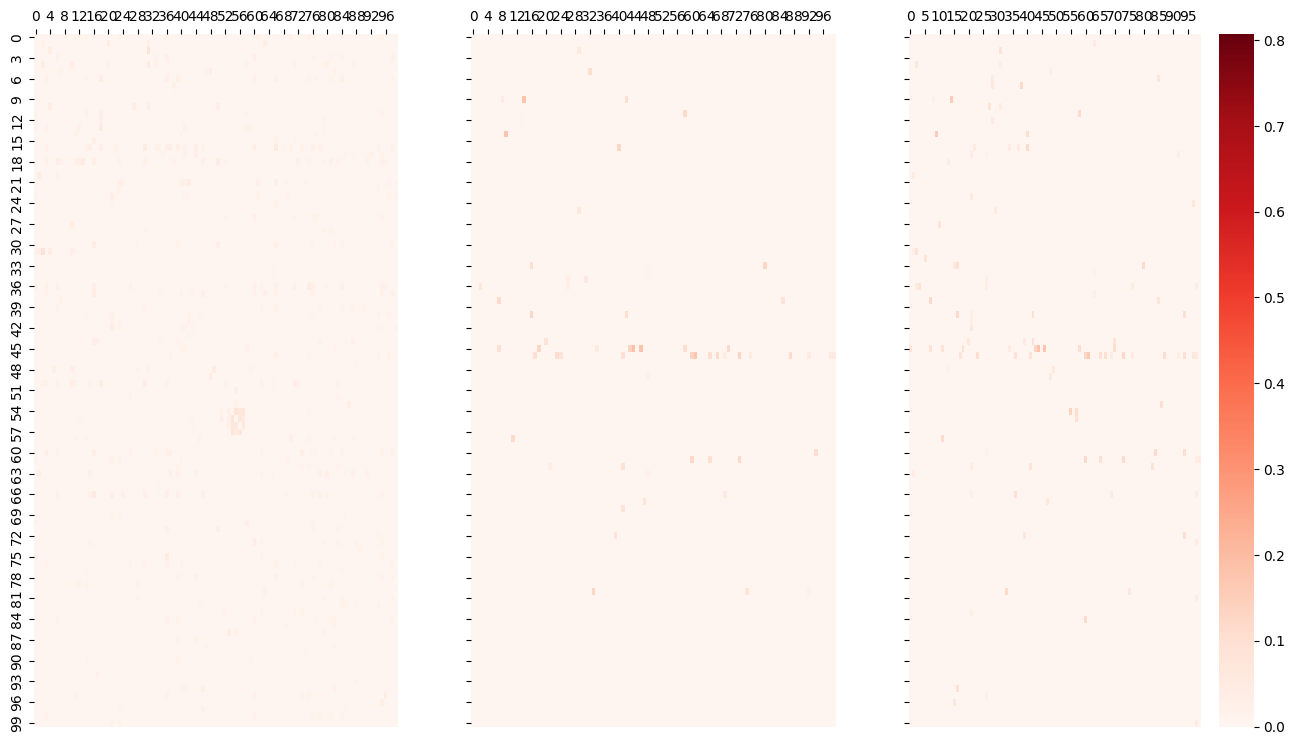

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


recommender_ItemKNNCF = ItemKNNCFRecommender(URM_train)
recommender_ItemKNNCF.fit()

recommender_ItemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_ItemKNNCBF.fit()

itemknn_cfcbf_recommender = ItemKNN_CFCBF_Hybrid_Recommender(URM_train, ICM_all)
itemknn_cfcbf_recommender.fit()

cf_sim = recommender_ItemKNNCF.W_sparse
cbf_sim = recommender_ItemKNNCBF.W_sparse
cfcbf_sim = itemknn_cfcbf_recommender.W_sparse

cf_sim_max = cf_sim.max()
cbf_sim_max = cbf_sim.max()
cfcbf_sim_max = cfcbf_sim.max()
vmax = np.max([cf_sim_max, cbf_sim_max, cfcbf_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(
    cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1, cmap="Reds"
)
sns.heatmap(
    cbf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2, cmap="Reds"
)
sns.heatmap(
    cfcbf_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3, cmap="Reds"
)
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

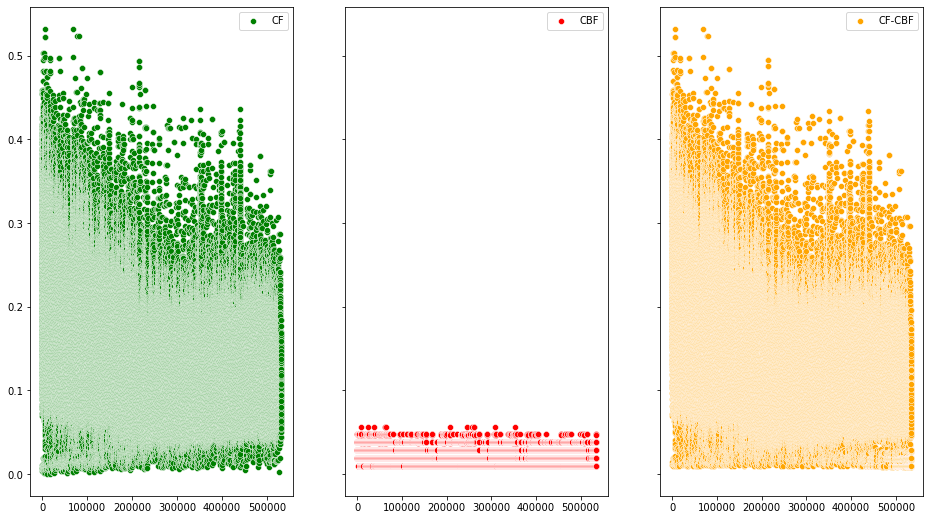

In [14]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
sns.scatterplot(data=cbf_sim.data, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_sim.data, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
C:\Users\ferra\Anaconda3\envs\RecSysFramework38\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


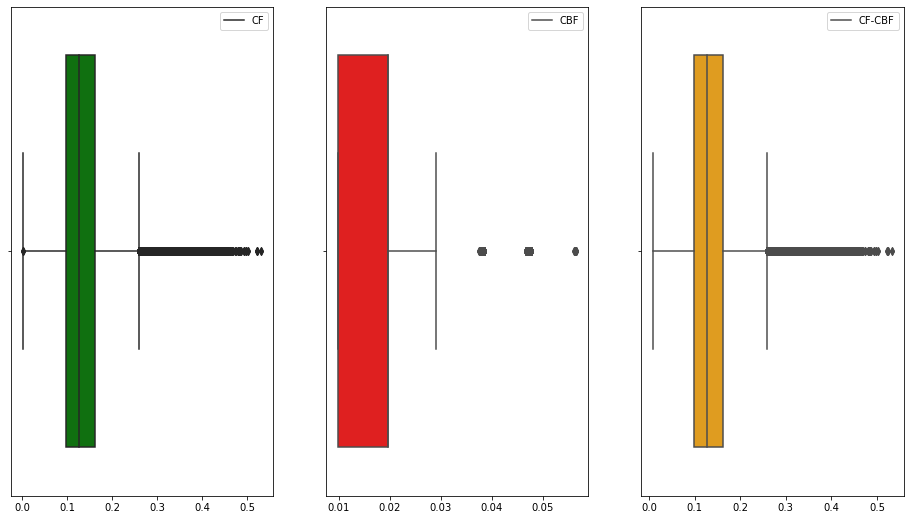

In [15]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=cbf_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=cfcbf_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

## Hybrid of models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In this case we cannot combine the model parameters themselves, rather we can combine the *predictions*.

In [16]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 1.94 sec


We can combine the predictions via a weighted average

In [17]:
user_id = 50

item_scores_itemknn = itemKNNCF._compute_item_score(user_id)
item_scores_itemknn

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)
item_scores_puresvd

array([-3.4351577e-04,  1.3840237e-03,  6.9613621e-04, ...,
       -3.8824372e-05, -4.9540598e-05, -3.9642196e-05], dtype=float32)

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

Again we use a weight

In [19]:
alpha = 0.7

new_item_scores = alpha * item_scores_itemknn + (1 - alpha) * item_scores_puresvd
new_item_scores

array([[-1.03054736e-04,  4.15207120e-04,  2.08840866e-04, ...,
        -1.16473120e-05, -1.48621803e-05, -1.18926591e-05]], dtype=float32)

Now we create a recommeder class. Note that again we can build a hybrid combining any number of models

In [21]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha=0.5)

result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
result_df

EvaluatorHoldout: Processed 35293 (100.0%) in 31.92 sec. Users per second: 1106


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,NOVELTY,AVERAGE_POPULARITY,DIVERSITY_MEAN_INTER_LIST,DIVERSITY_HERFINDAHL,COVERAGE_ITEM,COVERAGE_ITEM_HIT,ITEMS_IN_GT,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,0.072026,0.084271,0.057275,0.040728,0.046979,0.148709,0.081443,0.063809,0.274049,0.173915,0.001892,0.109284,0.998068,0.999608,0.544529,0.156712,0.988799,0.987604,0.270651,0.987604,0.178674,12.86769,0.999666,0.295472,0.871968,1.451161,0.154659
10,0.060865,0.105996,0.095009,0.026475,0.044145,0.164173,0.090319,0.074197,0.389822,0.206515,0.003801,0.103612,0.997003,0.999697,0.69825,0.228798,0.988799,0.987604,0.38499,0.987604,0.224027,13.21787,0.999755,0.370472,0.895698,1.375849,0.310674
15,0.053144,0.128264,0.122446,0.01994,0.04532,0.169529,0.099175,0.074119,0.457598,0.22133,0.005721,0.099842,0.996139,0.999741,0.779806,0.279033,0.988799,0.987604,0.451925,0.987604,0.253475,13.413079,0.999799,0.41917,0.908926,1.32579,0.467611


## Models with rating prediction vs ranking loss functions


Sometimes we have models that optimize different loss functions, one BPR (ranking) and another rating prediction (MSE). For instance:
- SLIMBPR and SLIM EN/MSE
- FunkSVD and MFBPR
- ...

This brings another important problem, for rank-based models there is no clear meaning for the *absolute value* of the prediction. A value of 15.245 may be low or high, depending on the *other* values.

In those cases it becomes essential to include a *normalization* on the weights, to ensure that the values are, at least, in the same range for all models. Many normalizations can be used: min/max, l1, l2, other nonlinear functions (sigmoid, ...)

In [8]:
BEST_SLIM_BPR = {
    "topK": 172,
    "epochs": 40,
    "symmetric": True,
    "sgd_mode": "adagrad",
    "lambda_i": 1.0865131473883948e-05,
    "lambda_j": 7.816972469298217e-05,
    "learning_rate": 0.05884497036877498,
}

slim_bpr_recommender = SLIM_BPR_Cython(URM_train)
slim_bpr_recommender.fit(**BEST_SLIM_BPR)

SLIM_BPR_Recommender: Automatic selection of fastest train mode. Available RAM is 23114.00 MB (75.10%) of 30779.00 MB, required is 5812.84 MB. Using dense matrix.
Processed 35736 (100.0%) in 1.14 sec. BPR loss is 4.94E-02. Sample per second: 31227
SLIM_BPR_Recommender: Epoch 1 of 40. Elapsed time 0.16 sec
Processed 35736 (100.0%) in 0.28 sec. BPR loss is 1.44E-01. Sample per second: 126067
SLIM_BPR_Recommender: Epoch 2 of 40. Elapsed time 0.29 sec
Processed 35736 (100.0%) in 0.41 sec. BPR loss is 2.26E-01. Sample per second: 87401
SLIM_BPR_Recommender: Epoch 3 of 40. Elapsed time 0.42 sec
Processed 35736 (100.0%) in 0.55 sec. BPR loss is 2.96E-01. Sample per second: 64901
SLIM_BPR_Recommender: Epoch 4 of 40. Elapsed time 0.56 sec
Processed 35736 (100.0%) in 0.68 sec. BPR loss is 3.29E-01. Sample per second: 52882
SLIM_BPR_Recommender: Epoch 5 of 40. Elapsed time 0.69 sec
Processed 35736 (100.0%) in 0.80 sec. BPR loss is 3.78E-01. Sample per second: 44478
SLIM_BPR_Recommender: Epoch 6 o

In [29]:
result_df, _ = evaluator_validation.evaluateRecommender(slim_bpr_recommender)
result_df

EvaluatorHoldout: Processed 35283 (100.0%) in 31.73 sec. Users per second: 1112


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
5,0.064705,0.076982,0.054847,0.037848,0.044868,0.149838,0.077579,0.059369,0.261627,0.168347,...,0.987324,0.258311,0.987324,0.089264,11.548664,0.998642,0.147598,0.782587,2.701874,0.142751
10,0.051912,0.093415,0.085155,0.023296,0.041618,0.163388,0.083584,0.064502,0.363433,0.193997,...,0.987324,0.358826,0.987324,0.11893,12.005756,0.999092,0.19665,0.813562,2.46093,0.288394
15,0.044546,0.111275,0.107035,0.017102,0.042415,0.168373,0.090637,0.06291,0.426636,0.20568,...,0.987324,0.421228,0.987324,0.139421,12.268568,0.999288,0.230531,0.831371,2.316789,0.435324


In [9]:
recommender_object = ScoresHybridRecommender(
    URM_train, itemknn_cfcbf_recommender, slim_bpr_recommender
)

In [17]:
def recommender_map10(x):
    norm, alpha = x
    recommender_object.fit(norm, alpha)
    result_df, _ = evaluator_validation.evaluateRecommender(recommender_object)
    return -result_df.loc[10]["MAP"]

In [35]:
from skopt import gp_minimize

optimisation_result = gp_minimize(
    recommender_map10,
    [
        [1, 2, np.inf, -np.inf],  # norm
        (0.0, 1.0, "uniform"),  # alpha
    ],
    n_jobs=-1,
    verbose=True,
    n_calls=30,
    callback=[lambda result: print("Current parameters are", result.x)]
)

Iteration No: 1 started. Evaluating function at random point.
EvaluatorHoldout: Processed 35322 (100.0%) in 2.42 min. Users per second: 244
Current parameters are [2, 0.776273888526424]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 145.0310
Function value obtained: -0.0281
Current minimum: -0.0281
Iteration No: 2 started. Evaluating function at random point.
EvaluatorHoldout: Processed 35322 (100.0%) in 27.11 sec. Users per second: 1303
Current parameters are [2, 0.776273888526424]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.1235
Function value obtained: -0.0281
Current minimum: -0.0281
Iteration No: 3 started. Evaluating function at random point.
EvaluatorHoldout: Processed 35322 (100.0%) in 26.88 sec. Users per second: 1314
Current parameters are [2, 0.776273888526424]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 26.8955
Function value obtained: -0.0253
Current minimum: -0.0281
Iteration No: 4 started. Evaluating

In [44]:
optimisation_result.x

[2, 0.7122605546043009]

In [10]:
recommender_object.fit(2, 0.7122605546043009)

In [11]:
def recommend(
    recommender: BaseRecommender,
    dataset: Dataset,
    user_ids: Iterable[str],
    chunk_size: int = 1000,
    cutoff: int = 10,
    **recommender_kwargs,
) -> list[list[str]]:
    user_indices = [dataset.user_original_ID_to_index[id_] for id_ in user_ids]
    recommendation_chunks: list[list[list]] = [
        recommender.recommend(
            user_indices[i : i + chunk_size],
            cutoff=cutoff,
            **recommender_kwargs,
        )
        for i in range(0, len(user_indices), chunk_size)
    ]
    item_index_to_id = {
        index: id_ for id_, index in dataset.item_original_ID_to_index.items()
    }
    recommendation_ids = [
        [item_index_to_id[recommendation_index] for recommendation_index in recommendation]
        for chunk in recommendation_chunks
        for recommendation in chunk
    ]
    return recommendation_ids

In [12]:
def encode_recommendation(recommendation: list[str]) -> str:
    return " ".join([item for item in recommendation])

In [13]:
recommendations = recommend(
    recommender_object, data_loaded, test_df["user_id"]
)
print(len(recommendations))
print(len(recommendations[0]))

34231
10


In [15]:
test_df["item_list"] = [
    encode_recommendation(recommendation)
    for recommendation in recommendations
]
test_df

,user_id,item_list
0,0,4462 2537 7405 12819 9911 512 2637 11699 516 3152
1,1,6348 14859 3667 14888 572 2827 3058 8492 2537 ...
2,2,22594 22649 29640 2775 16255 22625 22578 29963...
3,3,6827 26259 3207 25079 24570 13754 10470 9742 4...
4,4,3472 18314 9812 15695 9447 12643 18312 11653 3...
...,...,...
34226,35729,38024 37178 36866 28364 36844 36083 37510 3554...
34227,35730,36649 37874 27637 37098 33330 35958 37146 2713...
34228,35731,35394 36567 36548 35120 28135 28429 37109 3704...
34229,35734,36168 37755 37550 36609 37545 35918 36391 3688...


In [16]:
test_df.to_csv(SUBMISSION_PATH, index=False)

## Important note:


You can build a hybrid with any number of techniques and models, be advised however that optimizing them is difficult.
* If you use already trained and optimized models and try to combine them you have a weight per each model and possibly a normalization. If you put together 10 models it will be difficult for the optimizer to find good hyperparameters due to a number of problems, for example the noise introduced by the lower performing algorithms;
* If you decide to try to optimize both the hybrid hyperparameters and each single model hyperparameters all at once, you end up with hundreds of hyperparameters to optimize. In theory you could be able to find a better result, in practice you will likely not.
* Some strategies can be used to minimize this, for example some smart initial points you provide to the optimizer... Maybe you start from all the hyperparameter configurations of the single models taken independently that you have already optimized, you use them as initialization points for the optimizer and then you try to *further* optimize them as part of the hybrid. (may be complicated, result is not guaranteed) 

A good solution is to proceed incrementally. For example:
* Start with the best model and set a weight and normalization, let's say 1.0 and l1;
* Add the second-best model and try to create a hybrid of the two optimizing only weight and normalization of the model you are trying to add;
* Once the optimization concludes, check if the hybrid is better than before or not. If it is better keep the new hybrid, if not remove the second-best model.
* Continue trying to add the third-best, fourth-best and so on...
* If you are lucky every now and then a new model can be added and the quality improves. (again, result not guaranteed)


Alternatively you can combine the model predictions with more complex strategies, for example with XGBoost. This is usually the go-to approach for hybrids that we use in the international challenges but goes beyond the scope of this course.

# Some tricks, user-wise hybrids

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [38]:
import numpy as np
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([15, 13, 20, ..., 94, 30, 38], dtype=int32), (69878,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [39]:
block_size = int(len(profile_length) * 0.05)
block_size

3493

In [40]:
sorted_users = np.argsort(profile_length)
sorted_users

array([32755, 21863,  7680, ..., 14085, 65888, 57959], dtype=int64)

In [41]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print(
        "Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max(),
        )
    )

Group 0, #users in group 3493, average p.len 11.76, median 12.0, min 5, max 13
Group 1, #users in group 3493, average p.len 14.58, median 15.0, min 13, max 16
Group 2, #users in group 3493, average p.len 16.62, median 17.0, min 16, max 18
Group 3, #users in group 3493, average p.len 18.84, median 19.0, min 18, max 20
Group 4, #users in group 3493, average p.len 21.30, median 21.0, min 20, max 23
Group 5, #users in group 3493, average p.len 24.20, median 24.0, min 23, max 26
Group 6, #users in group 3493, average p.len 27.56, median 28.0, min 26, max 29
Group 7, #users in group 3493, average p.len 31.48, median 31.0, min 29, max 34
Group 8, #users in group 3493, average p.len 35.97, median 36.0, min 34, max 38
Group 9, #users in group 3493, average p.len 41.34, median 41.0, min 38, max 44
Group 10, #users in group 3493, average p.len 47.76, median 48.0, min 44, max 51
Group 11, #users in group 3493, average p.len 55.59, median 55.0, min 51, max 60
Group 12, #users in group 3493, average

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [ ]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import (
    MatrixFactorization_FunkSVD_Cython,
)
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {
    "TopPop": TopPop,
    "UserKNNCF": UserKNNCFRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "P3alpha": P3alphaRecommender,
    "RP3beta": RP3betaRecommender,
    "PureSVD": PureSVDRecommender,
    "NMF": NMFRecommender,
    "FunkSVD": MatrixFactorization_FunkSVD_Cython,
    "SLIMBPR": SLIM_BPR_Cython,
}

content_recommender_class = {
    "ItemKNNCBF": ItemKNNCBFRecommender,
    "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender,
}

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

for label, recommender_class in content_recommender_class.items():
    recommender_object = recommender_class(URM_train, ICM_all)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

TopPopRecommender: URM Detected 56 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 67565 (96.7%), 225.18 column/sec. Elapsed time 5.00 min
Similarity column 69878 (100.0%), 225.04 column/sec. Elapsed time 5.18 min
ItemKNNCFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
Similarity column 10681 (100.0%), 869.02 column/sec. Elapsed time 12.29 sec
P3alphaRecommender: URM Detected 56 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 56 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 56 ( 0.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 5.46 sec
NMFRecommender: URM Detected 56 ( 0.5%) items with no interactions.
NMFRecommender: Computing NMF decomposition...
NMFRecommender: Computing NMF decomposition... done in 5.40 min
MatrixFactorization_FunkSVD_Cython_Recomme

FUNK_SVD: Epoch 50 of 300. Elapsed time 6.56 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.33 sec. MSE loss 1.06E+00. Sample per second: 873431
FUNK_SVD: Epoch 51 of 300. Elapsed time 6.68 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.01 sec. MSE loss 1.06E+00. Sample per second: 798984
FUNK_SVD: Epoch 52 of 300. Elapsed time 6.81 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.11 sec. MSE loss 1.06E+00. Sample per second: 899703
FUNK_SVD: Epoch 53 of 300. Elapsed time 6.93 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.52 sec. MSE loss 1.05E+00. Sample per second: 850799
FUNK_SVD: Epoch 54 of 300. Elapsed time 7.05 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.75 sec. MSE loss 1.05E+00. Sample per second: 731372
FUNK_SVD: Epoch 55 of 300. Elapsed time 7.19 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.86 sec. MSE loss 1.05E+00. Sample per second: 814416
FUNK_SVD: Epoch 56 of 300. Elapsed time 7.31 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.01 sec. MSE loss 1.05E+00. Sample per second:

FUNK_SVD: Epoch 107 of 300. Elapsed time 13.91 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.65 sec. MSE loss 1.02E+00. Sample per second: 837096
FUNK_SVD: Epoch 108 of 300. Elapsed time 14.04 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.94 sec. MSE loss 1.02E+00. Sample per second: 715998
FUNK_SVD: Epoch 109 of 300. Elapsed time 14.17 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.77 sec. MSE loss 1.02E+00. Sample per second: 729656
FUNK_SVD: Epoch 110 of 300. Elapsed time 14.30 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.16 sec. MSE loss 1.02E+00. Sample per second: 784874
FUNK_SVD: Epoch 111 of 300. Elapsed time 14.43 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.39 sec. MSE loss 1.02E+00. Sample per second: 763271
FUNK_SVD: Epoch 112 of 300. Elapsed time 14.56 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.54 sec. MSE loss 1.02E+00. Sample per second: 749854
FUNK_SVD: Epoch 113 of 300. Elapsed time 14.70 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.03 sec. MSE loss 1.02E+00. Samp

FUNK_SVD: Processed 6401000 (100.0%) in 8.67 sec. MSE loss 1.01E+00. Sample per second: 737933
FUNK_SVD: Epoch 164 of 300. Elapsed time 21.19 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.08 sec. MSE loss 1.01E+00. Sample per second: 705229
FUNK_SVD: Epoch 165 of 300. Elapsed time 21.33 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.90 sec. MSE loss 1.01E+00. Sample per second: 810593
FUNK_SVD: Epoch 166 of 300. Elapsed time 21.46 min
FUNK_SVD: Processed 6401000 (100.0%) in 9.39 sec. MSE loss 1.01E+00. Sample per second: 681418
FUNK_SVD: Epoch 167 of 300. Elapsed time 21.60 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.53 sec. MSE loss 1.01E+00. Sample per second: 850499
FUNK_SVD: Epoch 168 of 300. Elapsed time 21.72 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.72 sec. MSE loss 1.01E+00. Sample per second: 828787
FUNK_SVD: Epoch 169 of 300. Elapsed time 21.84 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.47 sec. MSE loss 1.01E+00. Sample per second: 755614
FUNK_SVD: Epoch 170 of 300. E

FUNK_SVD: Epoch 220 of 300. Elapsed time 28.40 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.33 sec. MSE loss 9.94E-01. Sample per second: 768582
FUNK_SVD: Epoch 221 of 300. Elapsed time 28.53 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.35 sec. MSE loss 9.94E-01. Sample per second: 766286
FUNK_SVD: Epoch 222 of 300. Elapsed time 28.66 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.35 sec. MSE loss 9.93E-01. Sample per second: 767006
FUNK_SVD: Epoch 223 of 300. Elapsed time 28.80 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.31 sec. MSE loss 9.93E-01. Sample per second: 769884
FUNK_SVD: Epoch 224 of 300. Elapsed time 28.93 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.14 sec. MSE loss 9.94E-01. Sample per second: 786127
FUNK_SVD: Epoch 225 of 300. Elapsed time 29.06 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.62 sec. MSE loss 9.93E-01. Sample per second: 742803
FUNK_SVD: Epoch 226 of 300. Elapsed time 29.20 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.65 sec. MSE loss 9.93E-01. Samp

FUNK_SVD: Processed 6401000 (100.0%) in 8.79 sec. MSE loss 9.83E-01. Sample per second: 728375
FUNK_SVD: Epoch 277 of 300. Elapsed time 35.89 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.66 sec. MSE loss 9.84E-01. Sample per second: 835996
FUNK_SVD: Epoch 278 of 300. Elapsed time 36.00 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.86 sec. MSE loss 9.84E-01. Sample per second: 722362
FUNK_SVD: Epoch 279 of 300. Elapsed time 36.14 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.77 sec. MSE loss 9.83E-01. Sample per second: 730253
FUNK_SVD: Epoch 280 of 300. Elapsed time 36.27 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.85 sec. MSE loss 9.82E-01. Sample per second: 722792
FUNK_SVD: Epoch 281 of 300. Elapsed time 36.41 min
FUNK_SVD: Processed 6401000 (100.0%) in 8.45 sec. MSE loss 9.84E-01. Sample per second: 756985
FUNK_SVD: Epoch 282 of 300. Elapsed time 36.53 min
FUNK_SVD: Processed 6401000 (100.0%) in 7.81 sec. MSE loss 9.84E-01. Sample per second: 819289
FUNK_SVD: Epoch 283 of 300. E

Processed 69878 (100.0%) in 0.96 sec. BPR loss is 2.41E-02. Sample per second: 73017
SLIM_BPR_Recommender: Epoch 31 of 300. Elapsed time 22.38 sec
Processed 69878 (100.0%) in 1.58 sec. BPR loss is 2.48E-02. Sample per second: 44284
SLIM_BPR_Recommender: Epoch 32 of 300. Elapsed time 23.00 sec
Processed 69878 (100.0%) in 1.34 sec. BPR loss is 2.55E-02. Sample per second: 52056
SLIM_BPR_Recommender: Epoch 33 of 300. Elapsed time 23.76 sec
Processed 69878 (100.0%) in 1.05 sec. BPR loss is 2.66E-02. Sample per second: 66653
SLIM_BPR_Recommender: Epoch 34 of 300. Elapsed time 24.47 sec
Processed 69878 (100.0%) in 0.92 sec. BPR loss is 2.68E-02. Sample per second: 76237
SLIM_BPR_Recommender: Epoch 35 of 300. Elapsed time 25.34 sec
Processed 69878 (100.0%) in 1.66 sec. BPR loss is 2.78E-02. Sample per second: 42100
SLIM_BPR_Recommender: Epoch 36 of 300. Elapsed time 26.08 sec
Processed 69878 (100.0%) in 1.26 sec. BPR loss is 2.82E-02. Sample per second: 55509
SLIM_BPR_Recommender: Epoch 37 of

Processed 69878 (100.0%) in 0.99 sec. BPR loss is 6.47E-02. Sample per second: 70458
SLIM_BPR_Recommender: Epoch 87 of 300. Elapsed time 1.04 min
Processed 69878 (100.0%) in 1.59 sec. BPR loss is 6.54E-02. Sample per second: 43843
SLIM_BPR_Recommender: Epoch 88 of 300. Elapsed time 1.05 min
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 6.72E-02. Sample per second: 58732
SLIM_BPR_Recommender: Epoch 89 of 300. Elapsed time 1.06 min
Processed 69878 (100.0%) in 1.02 sec. BPR loss is 6.82E-02. Sample per second: 68466
SLIM_BPR_Recommender: Epoch 90 of 300. Elapsed time 1.07 min
Processed 69878 (100.0%) in 0.66 sec. BPR loss is 6.79E-02. Sample per second: 105244
SLIM_BPR_Recommender: Epoch 91 of 300. Elapsed time 1.08 min
Processed 69878 (100.0%) in 1.26 sec. BPR loss is 6.86E-02. Sample per second: 55487
SLIM_BPR_Recommender: Epoch 92 of 300. Elapsed time 1.09 min
Processed 69878 (100.0%) in 0.88 sec. BPR loss is 6.96E-02. Sample per second: 79073
SLIM_BPR_Recommender: Epoch 93 of 300.

Processed 69878 (100.0%) in 0.93 sec. BPR loss is 1.05E-01. Sample per second: 75314
SLIM_BPR_Recommender: Epoch 143 of 300. Elapsed time 1.67 min
Processed 69878 (100.0%) in 1.60 sec. BPR loss is 1.04E-01. Sample per second: 43670
SLIM_BPR_Recommender: Epoch 144 of 300. Elapsed time 1.68 min
Processed 69878 (100.0%) in 1.37 sec. BPR loss is 1.06E-01. Sample per second: 50955
SLIM_BPR_Recommender: Epoch 145 of 300. Elapsed time 1.70 min
Processed 69878 (100.0%) in 1.06 sec. BPR loss is 1.06E-01. Sample per second: 65821
SLIM_BPR_Recommender: Epoch 146 of 300. Elapsed time 1.71 min
Processed 69878 (100.0%) in 0.78 sec. BPR loss is 1.07E-01. Sample per second: 88916
SLIM_BPR_Recommender: Epoch 147 of 300. Elapsed time 1.72 min
Processed 69878 (100.0%) in 1.40 sec. BPR loss is 1.09E-01. Sample per second: 49904
SLIM_BPR_Recommender: Epoch 148 of 300. Elapsed time 1.73 min
Processed 69878 (100.0%) in 1.01 sec. BPR loss is 1.08E-01. Sample per second: 68938
SLIM_BPR_Recommender: Epoch 149 o

Processed 69878 (100.0%) in 1.52 sec. BPR loss is 1.40E-01. Sample per second: 46055
SLIM_BPR_Recommender: Epoch 199 of 300. Elapsed time 2.35 min
Processed 69878 (100.0%) in 1.44 sec. BPR loss is 1.42E-01. Sample per second: 48549
SLIM_BPR_Recommender: Epoch 200 of 300. Elapsed time 2.36 min
Processed 69878 (100.0%) in 1.09 sec. BPR loss is 1.43E-01. Sample per second: 63836
SLIM_BPR_Recommender: Epoch 201 of 300. Elapsed time 2.38 min
Processed 69878 (100.0%) in 0.91 sec. BPR loss is 1.43E-01. Sample per second: 76385
SLIM_BPR_Recommender: Epoch 202 of 300. Elapsed time 2.39 min
Processed 69878 (100.0%) in 1.88 sec. BPR loss is 1.45E-01. Sample per second: 37173
SLIM_BPR_Recommender: Epoch 203 of 300. Elapsed time 2.40 min
Processed 69878 (100.0%) in 1.81 sec. BPR loss is 1.46E-01. Sample per second: 38588
SLIM_BPR_Recommender: Epoch 204 of 300. Elapsed time 2.42 min
Processed 69878 (100.0%) in 1.46 sec. BPR loss is 1.47E-01. Sample per second: 47920
SLIM_BPR_Recommender: Epoch 205 o

Processed 69878 (100.0%) in 1.30 sec. BPR loss is 1.78E-01. Sample per second: 53629
SLIM_BPR_Recommender: Epoch 255 of 300. Elapsed time 3.03 min
Processed 69878 (100.0%) in 1.18 sec. BPR loss is 1.81E-01. Sample per second: 58865
SLIM_BPR_Recommender: Epoch 256 of 300. Elapsed time 3.04 min
Processed 69878 (100.0%) in 1.19 sec. BPR loss is 1.78E-01. Sample per second: 58816
SLIM_BPR_Recommender: Epoch 257 of 300. Elapsed time 3.06 min
Processed 69878 (100.0%) in 0.82 sec. BPR loss is 1.78E-01. Sample per second: 85108
SLIM_BPR_Recommender: Epoch 258 of 300. Elapsed time 3.07 min
Processed 69878 (100.0%) in 1.56 sec. BPR loss is 1.78E-01. Sample per second: 44872
SLIM_BPR_Recommender: Epoch 259 of 300. Elapsed time 3.08 min
Processed 69878 (100.0%) in 1.52 sec. BPR loss is 1.81E-01. Sample per second: 45782
SLIM_BPR_Recommender: Epoch 260 of 300. Elapsed time 3.10 min
Processed 69878 (100.0%) in 1.42 sec. BPR loss is 1.82E-01. Sample per second: 49216
SLIM_BPR_Recommender: Epoch 261 o

In [43]:
cutoff = 10

for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id + 1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print(
        "Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max(),
        )
    )

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(
        URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group
    )

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 3493, average p.len 11.76, median 12.0, min 5, max 13
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3491 (100.0%) in 6.52 sec. Users per second: 535
EvaluatorHoldout: Processed 3491 (100.0%) in 6.67 sec. Users per second: 524
EvaluatorHoldout: Processed 3491 (100.0%) in 6.16 sec. Users per second: 566
EvaluatorHoldout: Processed 3491 (100.0%) in 6.30 sec. Users per second: 554
EvaluatorHoldout: Processed 3491 (100.0%) in 6.32 sec. Users per second: 553
EvaluatorHoldout: Processed 3491 (100.0%) in 6.53 sec. Users per second: 534
EvaluatorHoldout: Processed 3491 (100.0%) in 8.72 sec. Users per second: 400
EvaluatorHoldout: Processed 3491 (100.0%) in 6.84 sec. Users per second: 510
EvaluatorHoldout: Processed 3491 (100.0%) in 7.06 sec. Users per second: 494
EvaluatorHoldout: Processed 3491 (100.0%) in 6.01 sec. Users per second: 581
EvaluatorHoldout: Process

EvaluatorHoldout: Processed 3492 (100.0%) in 4.98 sec. Users per second: 701
EvaluatorHoldout: Processed 3492 (100.0%) in 7.18 sec. Users per second: 487
EvaluatorHoldout: Processed 3492 (100.0%) in 7.18 sec. Users per second: 486
Group 8, #users in group 3493, average p.len 35.97, median 36.0, min 34, max 38
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 (100.0%) in 7.80 sec. Users per second: 448
EvaluatorHoldout: Processed 3493 (100.0%) in 6.13 sec. Users per second: 569
EvaluatorHoldout: Processed 3493 (100.0%) in 7.45 sec. Users per second: 469
EvaluatorHoldout: Processed 3493 (100.0%) in 7.26 sec. Users per second: 481
EvaluatorHoldout: Processed 3493 (100.0%) in 7.51 sec. Users per second: 465
EvaluatorHoldout: Processed 3493 (100.0%) in 5.57 sec. Users per second: 628
EvaluatorHoldout: Processed 3493 (100.0%) in 10.12 sec. Users per second: 345
EvaluatorHoldout: Proce

EvaluatorHoldout: Processed 3493 (100.0%) in 6.41 sec. Users per second: 545
EvaluatorHoldout: Processed 3493 (100.0%) in 10.52 sec. Users per second: 332
EvaluatorHoldout: Processed 3493 (100.0%) in 6.58 sec. Users per second: 531
EvaluatorHoldout: Processed 3493 (100.0%) in 7.16 sec. Users per second: 488
EvaluatorHoldout: Processed 3493 (100.0%) in 6.64 sec. Users per second: 526
EvaluatorHoldout: Processed 3493 (100.0%) in 8.54 sec. Users per second: 409
Group 16, #users in group 3493, average p.len 140.42, median 140.0, min 124, max 159
EvaluatorHoldout: Ignoring 69800 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 (100.0%) in 6.50 sec. Users per second: 537
EvaluatorHoldout: Processed 3493 (100.0%) in 7.51 sec. Users per second: 465
EvaluatorHoldout: Processed 3493 (100.0%) in 7.29 sec. Users per second: 479
EvaluatorHoldout: Processed 3493 (100.0%) in 7.08 sec. Users per second: 493
EvaluatorHoldout: 

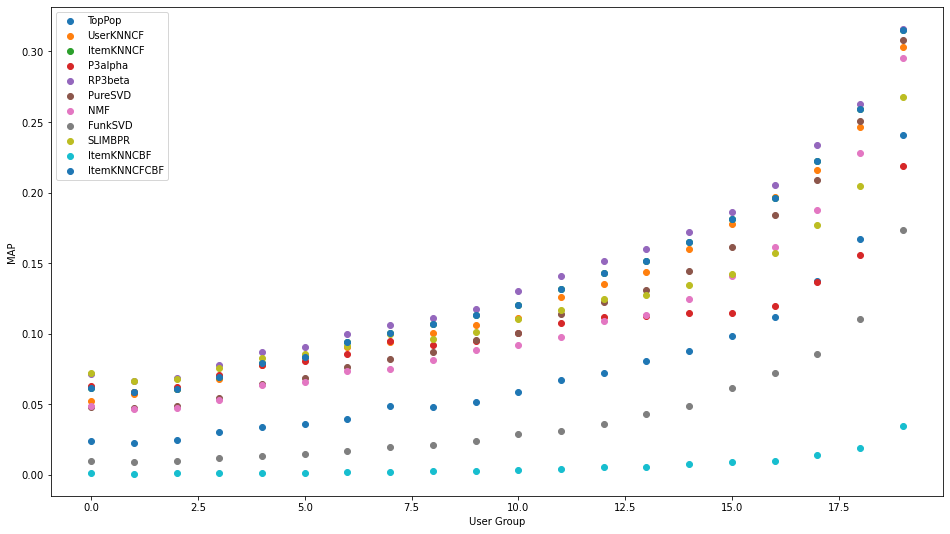

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label)
plt.ylabel("MAP")
plt.xlabel("User Group")
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types